# 🧠  **Ai Planet Hackathon Notebook :**

_In this notebook, we train both a RandomForest and an XGBoost classifier to predict whether a person is an "Adult" or "Senior" based on their biometrics. We’ll compare F1 scores and submit the best model’s predictions._

# Import All Important Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
import xgboost as xgb

%matplotlib inline
sns.set_style("whitegrid")

# Upload Data Files

In [9]:
from google.colab import files

# This will prompt you to upload 'Train_Data.csv' and 'Test_Data.csv'
uploaded = files.upload()

# Confirm upload
print("Uploaded files:", uploaded.keys())

Saving Test_Data.csv to Test_Data.csv
Saving Train_Data.csv to Train_Data.csv
Uploaded files: dict_keys(['Test_Data.csv', 'Train_Data.csv'])


# Load Datasets

In [11]:
train_df = pd.read_csv('Train_Data.csv')
test_df  = pd.read_csv('Test_Data.csv')

print("✅ Training data shape:", train_df.shape)
print("✅ Test data shape:    ", test_df.shape)

✅ Training data shape: (1966, 9)
✅ Test data shape:     (312, 8)


# Target Mapping & Cleaning

In [13]:
if train_df['age_group'].dtype == 'object':
    train_df['age_group'] = train_df['age_group'].map({'Adult': 0, 'Senior': 1})
    if train_df['age_group'].isnull().sum() > 0:
        print("Warning: Some values in 'age_group' did not map correctly. Check the mapping.")

# Drop rows with missing target values

In [14]:
if train_df['age_group'].isnull().sum() > 0:
    print("Dropping rows with missing target values")
    train_df = train_df.dropna(subset=['age_group'])

Dropping rows with missing target values


# Quick data overview

In [15]:
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("Target distribution:\n", train_df['age_group'].value_counts())

Training data shape: (1952, 9)
Test data shape: (312, 8)
Target distribution:
 age_group
0.0    1638
1.0     314
Name: count, dtype: int64


# **Exploratory Data Analysis**
# _Visualize distributions for continuous features_

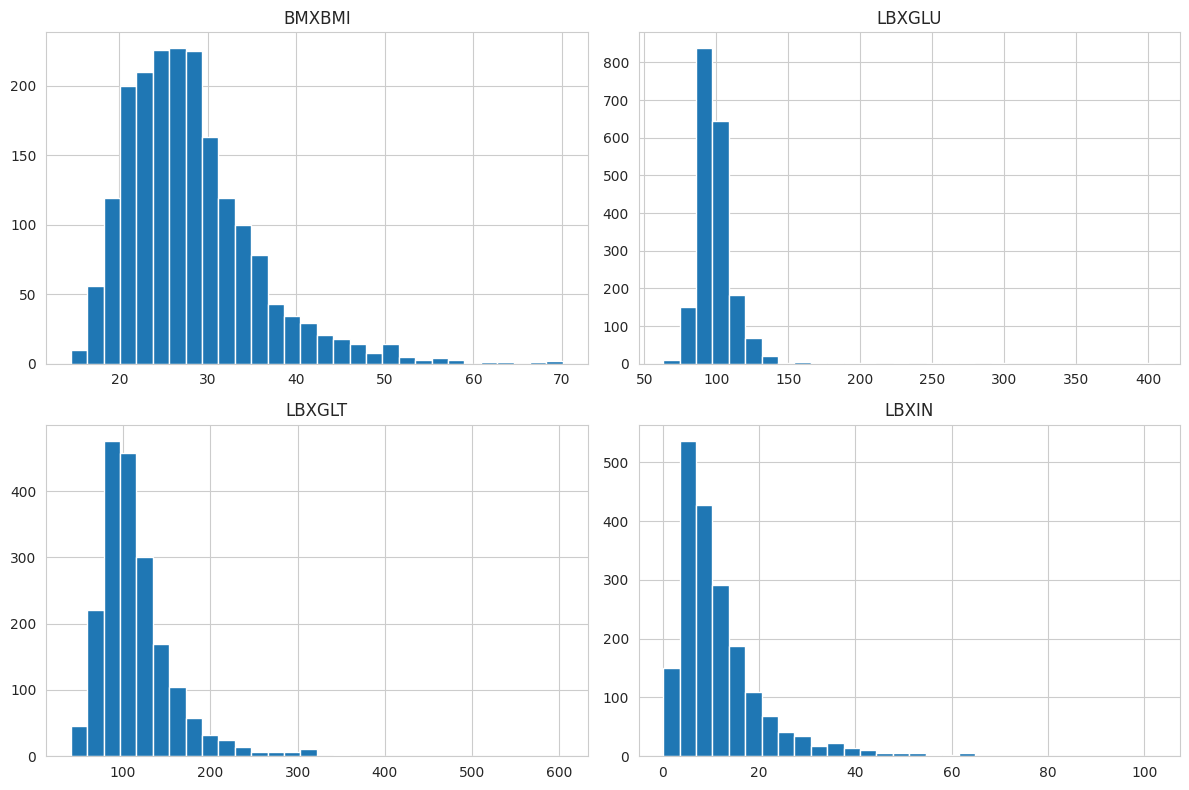

In [16]:
continuous_features = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
train_df[continuous_features].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Separate Features and Target

In [17]:
X = train_df.drop(columns=['SEQN', 'age_group'])
y = train_df['age_group']

# Pre-Imputation for Missing Values in Features

In [18]:
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split Data into Training and Validation Sets

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42)

# **Prepare Model Pipelines**

#_Pipeline for RandomForest_

In [20]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# _Pipeline for XGBoost_

In [21]:
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

# Hyperparameter Tuning using GridSearchCV
_Create a scorer with zero_division=0 so that any undefined precision/recall returns 0_

In [22]:
scorer = make_scorer(f1_score, zero_division=0)

# _RandomForest grid parameters_

In [23]:
param_grid_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid_rf,
    cv=StratifiedKFold(5),
    scoring=scorer,
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
print("Best parameters for RandomForest:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_
val_preds_rf = best_rf.predict(X_val)
f1_rf = f1_score(y_val, val_preds_rf, zero_division=0)
print("Validation F1 Score (RandomForest): {:.4f}".format(f1_rf))

Best parameters for RandomForest: {'rf__max_depth': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Validation F1 Score (RandomForest): 0.2923


# _XGBoost grid parameters_

In [24]:
param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}

grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid=param_grid_xgb,
    cv=StratifiedKFold(5),
    scoring=scorer,
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", grid_xgb.best_params_)
best_xgb = grid_xgb.best_estimator_
val_preds_xgb = best_xgb.predict(X_val)
f1_xgb = f1_score(y_val, val_preds_xgb, zero_division=0)
print("Validation F1 Score (XGBoost): {:.4f}".format(f1_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:57:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 300}
Validation F1 Score (XGBoost): 0.2828


# Choose the Better Model

In [25]:
if f1_xgb >= f1_rf:
    final_model = best_xgb
    print("Choosing XGBoost as the final model.")
else:
    final_model = best_rf
    print("Choosing RandomForest as the final model.")

Choosing RandomForest as the final model.


# Preprocess the Test Set

In [26]:
X_test = test_df.drop(columns=['SEQN'])
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Predict on the Test Set and Create Submission File

In [27]:
final_preds = final_model.predict(X_test_imputed)
submission = pd.DataFrame({'age_group': final_preds})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!
